In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [2]:
import torch
import torchvision
# import torchaudio
import random
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
from PIL import Image
import pathlib
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from tqdm.autonotebook import tqdm
import IPython.display as ipd
import torchvision.transforms as T

C:\Users\mishr\AppData\Local\Temp\ipykernel_21600\653414675.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
height=width= 128

In [4]:
train_trms = T.Compose([ 
    T.Resize((height, width)),  # Replace 'height' and 'width' with desired dimensions
    T.ToTensor()
])

val_trms = T.Compose([ 
    T.Resize((height, width)),  # Replace 'height' and 'width' with desired dimensions
    T.ToTensor()
])


In [5]:
 
d=r'M:\iitb\ml\project\dataset\my_data'

In [6]:

train_data = torchvision.datasets.ImageFolder(root = f'{d}/train/', transform = train_trms)
val_data = torchvision.datasets.ImageFolder(root = f'{d}/val/', transform = val_trms)
test_data = torchvision.datasets.ImageFolder(root = f'{d}/test', transform = val_trms)


In [7]:
def Encode(data):
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder

def Decoder(data):
    classes = data.classes
    
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [8]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
#         print(type(image))
        label = int(label)
        encoder = Encode(data)
        l = encoder[label]
       
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

In [9]:
# class_plot(train_data)

In [10]:
batch_size=4

In [11]:
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_data, batch_size, num_workers=4, pin_memory=True)
# test_dl2 = DataLoader(test_data2, batch_size, num_workers=4, pin_memory=True)

In [12]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))
class MultiImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

In [13]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [14]:
@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
NUM_CLASSES=len(os.listdir(f'{d}/train'))
print('num_classes', NUM_CLASSES)

num_classes 7


In [17]:
device = get_default_device()
device

device(type='cpu')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device) 

In [57]:
abz=50176 

In [ ]:
 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Conv2d, self).__init__()
        self.padding = 12  # Adjust padding based on kernel size
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=0)  # No padding here

    def forward(self, x):
        x_padded = self.pad(x, self.padding)

        output = self.conv(x_padded)
        return output

    def pad(self, x, padding):
        batch_size, channels, height, width = x.size()

        # Circular padding along height dimension
        top = x[:, :, -padding:, :]
        bottom = x[:, :, :padding, :]
        x_padded = torch.cat([top, x, bottom], dim=2)

        # Circular padding along width dimension
        left = x_padded[:, :, :, -padding:]
        right = x_padded[:, :, :, :padding]
        x_padded = torch.cat([left, x_padded, right], dim=3)

        return x_padded
 

class ImageClassifier(MultiImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super(ImageClassifier, self).__init__()
        self.conv1 = Conv2d(in_channels, 64, 3)
        self.conv2 = Conv2d(64, 128, 3)
        self.conv3 = Conv2d(128,256, 3) 

        self.fc1 = nn.Linear(abz , 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 3)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 3)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 3)
        # x = F.relu(self.conv4(x))
        # x = F.max_pool2d(x, 3)
        # x = F.relu(self.conv5(x))
        # x = F.max_pool2d(x, 3)
        x = x.view(x.size(0), -1) 
        # x = torch.flatten(x) # Flatten the output tensor
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = (self.fc2(x))
         
        return x


    def training_step(self, batch):
        images, labels = batch
        images = images.to(self.conv1.conv.weight.device)  # Convert input to the same device as model parameters
        labels = labels.to(self.conv1.conv.weight.device)  # Convert labels to the same device as model parameters
        out = self(images)  # Forward pass
        loss = F.cross_entropy(out, labels)  
        return loss

 
in_channels = 3
num_classes =NUM_CLASSES
 
model = ImageClassifier(in_channels, num_classes)

model = model.to(device)


In [59]:

from torchsummary import summary
 
summary(model, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 148, 148]           4,864
    PeriodicConv2d-2         [-1, 64, 148, 148]               0
            Conv2d-3          [-1, 128, 69, 69]         204,928
    PeriodicConv2d-4          [-1, 128, 69, 69]               0
            Conv2d-5          [-1, 256, 43, 43]         819,456
    PeriodicConv2d-6          [-1, 256, 43, 43]               0
            Linear-7                  [-1, 256]      12,845,312
            Linear-8                    [-1, 7]           1,799
Total params: 13,876,359
Trainable params: 13,876,359
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 37.91
Params size (MB): 52.93
Estimated Total Size (MB): 91.04
----------------------------------------------------------------


In [43]:
torch.cuda.empty_cache()

In [60]:
epochs = 25
max_lr = 0.00001
grad_clip = 0.1
weight_decay = 1e-6
opt_func = torch.optim.Adam

In [25]:
%%time
# history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
#                          grad_clip=grad_clip, 
#                          weight_decay=weight_decay, 
#                          opt_func=opt_func)

CPU times: total: 0 ns
Wall time: 0 ns


In [61]:
save_path = 'c12model.pth'
model = torch.load(save_path) 
# torch.save(model, save_path)

In [27]:

from sklearn.metrics import classification_report

In [45]:
class_labels = train_data.classes

# Print the label names
print(class_labels)

['BHAIRAVI', 'BHOPALI', 'BIHAG', 'DES', 'JOG', 'KEDAR', 'MALKAUNS']


In [46]:

from sklearn.metrics import precision_score, recall_score, f1_score

In [62]:
 
test_loader = test_dl

# Set the model to evaluation mode
model.eval()

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test data
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs to the device (e.g., GPU) if available
        inputs = inputs.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute predicted labels
        _, predicted = torch.max(outputs, 1)

        # Collect true labels and predicted labels
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

# Compute precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print or store the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
# Generate classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print(report)

Precision: 0.3526
Recall: 0.4152
F1-score: 0.3706
              precision    recall  f1-score   support

           0       0.17      0.25      0.21        16
           1       0.15      0.04      0.06        49
           2       0.73      0.81      0.77        43
           3       0.08      0.06      0.07        18
           4       0.58      0.95      0.72        44
           5       0.13      0.12      0.13        32
           6       0.62      0.67      0.64        39

    accuracy                           0.47       241
   macro avg       0.35      0.42      0.37       241
weighted avg       0.40      0.47      0.42       241



In [63]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.preprocessing import LabelEncoder
# Assuming you have a model named 'model' and a function 'get_predictions'
# that returns the predictions for a single image.

model.eval()

correct_file_names = []

# Iterate through the test folder
for root, _, files in os.walk(r'M:\iitb\ml\project\dataset\my_data\test'):
    for file in files:
        # Assuming 'val_trms' is your validation transform
        image_path = os.path.join(root, file)
        # print(image_path)
        image = val_trms(Image.open(image_path).convert("RGB"))
        image = image.unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            image = image.to(device)
            output = model(image)
            prediction = torch.argmax(output, dim=1).item()

        true_label = image_path 
 
        components = image_path.split(os.path.sep)
        true_label = components[-2]
        true_label_array = np.array([true_label])
 
        true_label_array_with_dim = true_label_array[:, np.newaxis]
        convertor = LabelEncoder()  
        true_label = convertor.fit_transform(true_label_array_with_dim ) 
 
         

        if prediction == true_label:
            correct_file_names.append(file)

# Now, correct_file_names contains the file names of the correctly predicted images.
print(correct_file_names)


c:\Users\mishr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mishr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mishr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mishr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.p

['BHAIRAVI_1.jpg', 'BHAIRAVI_2.jpg', 'BHAIRAVI_3.jpg', 'BHAIRAVI_4.jpg', 'BHOPALI_19.jpg', 'BHOPALI_26.jpg', 'BHOPALI_28.jpg', 'BHOPALI_29.jpg', 'BHOPALI_63.jpg', 'BHOPALI_65.jpg', 'BIHAG_77.jpg', 'DES_111.jpg', 'DES_115.jpg', 'DES_123.jpg', 'DES_1724.jpg', 'KEDAR_3062.jpg', 'MALKAUNS_197.jpg', 'MALKAUNS_201.jpg', 'MALKAUNS_202.jpg', 'MALKAUNS_210.jpg', 'MALKAUNS_213.jpg', 'MALKAUNS_214.jpg', 'MALKAUNS_232.jpg']


c:\Users\mishr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [64]:
import torch
from torchvision import models
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from torchvision.utils import make_grid



In [65]:
gradcam_pp = GradCAMpp(model, model.conv3)

In [69]:
from PIL import Image
import PIL

import torchvision.transforms as transforms 
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision import transforms


In [67]:
imge=9

In [71]:
import numpy as np

# Parameters
hop_length = 256
sampling_rate = 22050  # Adjust this to your actual sampling rate
spectrogram_shape = (128, 128)

In [ ]:
# for imge in range(len(correct_file_names)):
#     print(correct_file_names[imge].split('_')[0],correct_file_names[imge])

In [109]:
for imge in range(len(correct_file_names)):
    img_path = f"M:/iitb/ml/project/dataset/my_data/test/{correct_file_names[imge].split('_')[0]}/{correct_file_names[imge]}"
    print(img_path)

    pil_img = PIL.Image.open(img_path)
   

    # %%
    torch_img = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])(pil_img).to(device)
    normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
    gradcam_pp = GradCAMpp(model, model.conv3)
    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, normed_torch_img)
    resize_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128,128)),  # Adjust the size to match your input image size
        transforms.ToTensor()
    ])

    # Resize the heatmap
    resized_heatmap = resize_transform(heatmap_pp)

    # Convert tensor to a numpy array for visualization
    heatmap_np = np.transpose(resized_heatmap.squeeze().cpu().numpy(), (1, 2, 0))

    # Apply binary thresholding to the heatmap
    threshold = 0.5  # Adjust the threshold as needed
    binary_heatmap = cv2.threshold(heatmap_np, threshold, 1, cv2.THRESH_BINARY)[1]
    binary_image=binary_heatmap

    # Find the x-axis indices of white pixels
    white_pixel_indices = np.where(binary_image == 1)

    # Get unique x-axis indices
    unique_x_indices = np.unique(white_pixel_indices[1])

    # Create a list to store the ranges
    x_ranges = []

    # Iterate through the unique indices to create ranges
    start_index = end_index = unique_x_indices[0]
    for index in unique_x_indices[1:]:
        if index == end_index + 1:
            end_index = index
        else:
            if start_index == end_index:
                x_ranges.append(start_index)
            else:
                x_ranges.append((start_index, end_index))
            start_index = end_index = index

    # Add the last range if needed
    if start_index == end_index:
        x_ranges.append(start_index)
    else:
        x_ranges.append((start_index, end_index))
    time_intervals = []

    for x_range in x_ranges:
        start_index, end_index = x_range
        start_time = (start_index * hop_length) / sampling_rate
        end_time = (end_index * hop_length) / sampling_rate
        time_intervals.append((start_time, end_time))
        # print(time_intervals)
        np.savetxt(f'Raag_pred_labels/{correct_file_names[imge]}.txt', time_intervals, fmt='%.6f', delimiter='\t')

    print("Time intervals have been saved to time_intervals.txt")




M:/iitb/ml/project/dataset/my_data/test/BHAIRAVI/BHAIRAVI_1.jpg
Time intervals have been saved to time_intervals.txt
M:/iitb/ml/project/dataset/my_data/test/BHAIRAVI/BHAIRAVI_2.jpg
Time intervals have been saved to time_intervals.txt
M:/iitb/ml/project/dataset/my_data/test/BHAIRAVI/BHAIRAVI_3.jpg
Time intervals have been saved to time_intervals.txt
M:/iitb/ml/project/dataset/my_data/test/BHAIRAVI/BHAIRAVI_4.jpg
Time intervals have been saved to time_intervals.txt
M:/iitb/ml/project/dataset/my_data/test/BHOPALI/BHOPALI_19.jpg
Time intervals have been saved to time_intervals.txt
M:/iitb/ml/project/dataset/my_data/test/BHOPALI/BHOPALI_26.jpg
Time intervals have been saved to time_intervals.txt
M:/iitb/ml/project/dataset/my_data/test/BHOPALI/BHOPALI_28.jpg
Time intervals have been saved to time_intervals.txt
M:/iitb/ml/project/dataset/my_data/test/BHOPALI/BHOPALI_29.jpg
Time intervals have been saved to time_intervals.txt
M:/iitb/ml/project/dataset/my_data/test/BHOPALI/BHOPALI_63.jpg
Time 

In [108]:
img_path = f"M:/iitb/ml/project/dataset/my_data/test/{correct_file_names[imge].split('_')[0]}/{correct_file_names[imge]}"
 

pil_img = PIL.Image.open(img_path)
pil_img

# %%
torch_img = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

In [74]:
mask_pp, _ = gradcam_pp(normed_torch_img)
heatmap_pp, result_pp = visualize_cam(mask_pp, normed_torch_img)

In [75]:
heatmap_pp

tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.4784, 0.4157, 0.4157],
         [1.0000, 1.0000, 1.0000,  ..., 0.4784, 0.4157, 0.4157],
         [1.0000, 1.0000, 1.0000,  ..., 0.5882, 0.4941, 0.4941],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1412, 0.1412, 0.1412,  ..., 1.0000, 1.0000, 1.0000],
         [0.1412, 0.1412, 0.1412,  ..., 1.0000, 1.0000, 1.0000],
         [0.0941, 0.0941, 0.1725,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.7686, 0.7686, 0.4549,  ..., 0.9569, 0.8784, 0.8784],
         [0.5804, 0.5804, 0.3294,  ..., 0.8627, 0.8471, 0.8471],
         [0.5804, 0.5804, 0.3294,  ..., 0.8627, 0.8471, 0.8471]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.5255, 0.5882, 0.5882],
         [0.0000, 0.0000, 0.0000,  ..., 0.5255, 0.5882, 0.5882],
         [0.0000, 0.0000, 0.0000,  ..., 0.4157, 0.5098, 0.

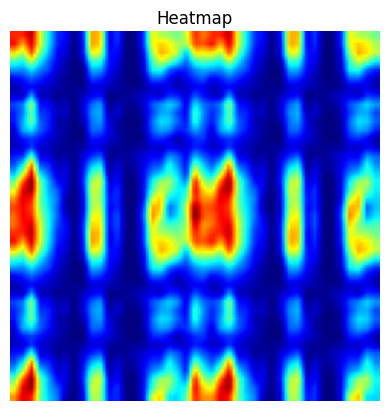

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image

 
heatmap_np = np.transpose(heatmap_pp.squeeze().cpu().numpy(), (1, 2, 0)) 

# Display the heatmap
plt.imshow(heatmap_np, cmap='jet')
plt.title('Heatmap')
plt.axis('off')
plt.show()



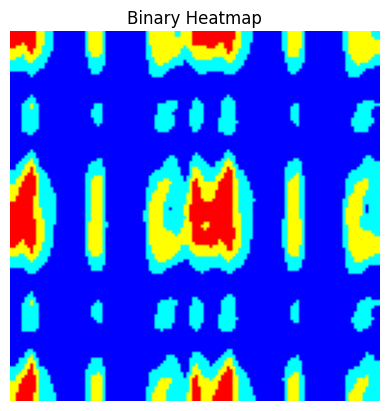

In [77]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision import transforms

# Resize the heatmap to match the input image dimensions
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),  # Adjust the size to match your input image size
    transforms.ToTensor()
])

# Resize the heatmap
resized_heatmap = resize_transform(heatmap_pp)

# Convert tensor to a numpy array for visualization
heatmap_np = np.transpose(resized_heatmap.squeeze().cpu().numpy(), (1, 2, 0))

# Apply binary thresholding to the heatmap
threshold = 0.5  # Adjust the threshold as needed
binary_heatmap = cv2.threshold(heatmap_np, threshold, 1, cv2.THRESH_BINARY)[1]

# Display the binary heatmap
plt.imshow(binary_heatmap, cmap='gray')  # Use 'gray' colormap for binary images
plt.title('Binary Heatmap')
plt.axis('off')
plt.show()


In [78]:
binary_image=binary_heatmap

In [79]:
import numpy as np 
# binary_image = np.array([
#     [0, 0, 0, 0, 0, 0, 0, 1,1,0,0,1,1,0,0,0,1,1,0,0],
#     [0, 0, 1, 1, 0, 0, 0, 1,1,0,0,1,1,0,0,0,1,1,0,0],
#     [0, 0, 1, 1, 0, 0, 0, 1,1,0,0,1,1,0,0,0,1,1,0,0],
#     [0, 0, 0, 0, 0, 0, 0, 1,1,0,0,1,1,0,0,0,1,1,0,0],
# ])

# Find the x-axis indices of white pixels
white_pixel_indices = np.where(binary_image == 1)

# Get unique x-axis indices
unique_x_indices = np.unique(white_pixel_indices[1])

# Create a list to store the ranges
x_ranges = []

# Iterate through the unique indices to create ranges
start_index = end_index = unique_x_indices[0]
for index in unique_x_indices[1:]:
    if index == end_index + 1:
        end_index = index
    else:
        if start_index == end_index:
            x_ranges.append(start_index)
        else:
            x_ranges.append((start_index, end_index))
        start_index = end_index = index

# Add the last range if needed
if start_index == end_index:
    x_ranges.append(start_index)
else:
    x_ranges.append((start_index, end_index))

# Display the list of ranges
# print("X-axis index ranges of white pixels:", x_ranges)


##########time_instance*sr/hop lenght=x_axus_value%%%%%%%%%%%%%%%%%%%%%%%%

In [80]:
import numpy as np

# Parameters
hop_length = 256
sampling_rate = 22050 

# X-axis index ranges of white pixels
# x_ranges = [(2, 3), (7, 8), (11, 12), (16, 17)]

# Calculate time intervals for each range
time_intervals = []

for x_range in x_ranges:
    start_index, end_index = x_range
    start_time = (start_index * hop_length) / sampling_rate
    end_time = (end_index * hop_length) / sampling_rate
    time_intervals.append((start_time, end_time))

# Save time intervals to a text file
np.savetxt(f'Raag_pred_labels/{correct_file_names[imge]}.txt', time_intervals, fmt='%.6f', delimiter='\t')

print("Time intervals have been saved to time_intervals.txt")


Time intervals have been saved to time_intervals.txt


In [81]:

# # Parameters
# hop_length = 256
# sampling_rate = 44100
# total_audio_length = 30  # seconds

# # # Given time ranges
# # time_ranges = [(0.12770975056689343, 0.13931972789115646), (0.18575963718820862, 0.19736961451247165)]
# bn=[]
# for i in correct_file_names:
# # Load time intervals from the text file
#     time_intervals = np.loadtxt(f'M:\iitb\ml\project\pcode\Raag_pred_Labels\{i}.txt', delimiter='\t')
# # 
#     print("Time intervals read from the file:")
#     print(time_intervals)

#     # Convert the time intervals to a list of tuples
#     time_ranges = [(start, end) for start, end in time_intervals]

#     # print("Time ranges:")
#     # print(time_ranges)


#     # Calculate corresponding indices in the binary array
#     binary_array_length = int(total_audio_length * sampling_rate / hop_length)
#     binary_array = np.zeros(binary_array_length, dtype=int)

#     for time_range in time_ranges:
#         start_time, end_time = time_range
#         start_index = int(start_time * sampling_rate / hop_length)
#         end_index = int(end_time * sampling_rate / hop_length)
#         binary_array[start_index:end_index + 1] = 1

#     # Print the binary array
#     print("Binary Array:")
#     print(binary_array)
#     bn.append(binary_array)



In [82]:
# import os
# import numpy as np

# def process_text_file(file_path, total_audio_length, sampling_rate, hop_length):
#     try:
#         # Load time intervals from the file
#         time_intervals = np.loadtxt(file_path, delimiter='\t')

#         print("Time intervals read from the file:")
#         print(time_intervals)

#         # Check if time_intervals is a 1D array (for a single row file)
#         if time_intervals.ndim == 1:
#             time_intervals = np.array([time_intervals])

#         # Convert the time intervals to a list of tuples
#         time_ranges = [(start, end) for start, end in time_intervals]

#         # Calculate corresponding indices in the binary array
#         binary_array_length = int(total_audio_length * sampling_rate / hop_length)
#         binary_array = np.zeros(binary_array_length, dtype=int)

#         for time_range in time_ranges:
#             start_time, end_time = time_range
#             start_index = int(start_time * sampling_rate / hop_length)
#             end_index = int(end_time * sampling_rate / hop_length)
#             binary_array[start_index:end_index + 1] = 1

#         # Print the binary array
#         print("Binary Array:")
#         print(binary_array)
#         bn.append(binary_array)

#     except Exception as e:
#         print(f"Error processing file {file_path}: {e}")

# # Set your parameters
# total_audio_length = 30  # Replace with the actual total audio length
# sampling_rate = 44100/2  # Replace with the actual sampling rate
# hop_length = 512/2  # Replace with the actual hop length

# # Specify the folder containing text files
# folder_path = 'M:/iitb/ml/project/pcode/Raag_pred_Labels/'

# # Initialize a list to store binary arrays
# bn = []

# # Iterate through text files in the folder
# for i, filename in enumerate(os.listdir(folder_path)):
#     if filename.endswith(".txt"):
#         file_path = os.path.join(folder_path, filename)
#         print(f"Processing file {i+1}/{len(os.listdir(folder_path))}: {file_path}")
        
#         # Process the file and get the binary array
#         process_text_file(file_path, total_audio_length, sampling_rate, hop_length)

# # Convert the list to a NumPy array
# bn = np.array(bn)
# print("Shape of bn:", bn.shape)


In [83]:
# import os
# import numpy as np

# def process_text_file(file_path, total_audio_length, sampling_rate, hop_length):
#     try:
#         # Load time intervals from the file using genfromtxt to handle non-numeric values
#         time_intervals = np.genfromtxt(file_path, delimiter='\t', usecols=(0, 1), dtype=float, invalid_raise=False)

#         # Check if time_intervals is a 1D array (for a single row file)
#         if time_intervals.ndim == 1:
#             time_intervals = np.array([time_intervals])

#         # Convert the time intervals to a list of tuples
#         time_ranges = [(start, end) for start, end in time_intervals]

#         # Calculate corresponding indices in the binary array
#         binary_array_length = int(total_audio_length * sampling_rate / hop_length)
#         binary_array = np.zeros(binary_array_length, dtype=int)

#         for time_range in time_ranges:
#             start_time, end_time = time_range
#             start_index = int(start_time * sampling_rate / hop_length)
#             end_index = int(end_time * sampling_rate / hop_length)
#             binary_array[start_index:end_index + 1] = 1

#         # Print the binary array
#         print("Binary Array:")
#         print(binary_array)
#         gn.append(binary_array)

#     except Exception as e:
#         print(f"Error processing file {file_path}: {e}")

# # Set your parameters
# total_audio_length = 30  # Replace with the actual total audio length
# sampling_rate = 44100/2 # Replace with the actual sampling rate
# hop_length = 512/2  # Replace with the actual hop length

# # Specify the folder containing text files
# folder_path = 'M:/iitb/ml/project/pcode/Raag_gold_Labels/'

# # Initialize a list to store binary arrays
# gn = []

# # Iterate through text files in the folder
# for i, filename in enumerate(os.listdir(folder_path)):
#     if filename.endswith(".txt"):
#         file_path = os.path.join(folder_path, filename)
#         print(f"Processing file {i+1}/{len(os.listdir(folder_path))}: {file_path}")
        
#         # Process the file and get the binary array
#         process_text_file(file_path, total_audio_length, sampling_rate, hop_length)

# # Convert the list to a NumPy array
# gn = np.array(gn)
# print("Shape of gn:", gn.shape)


In [93]:
import os
import numpy as np

def process_text_file(file_path, total_audio_length, sampling_rate, hop_length):
    try:
        # Load time intervals from the file using genfromtxt to handle non-numeric values
        time_intervals = np.genfromtxt(file_path, delimiter='\t', usecols=(0, 1), dtype=float, invalid_raise=False)

        # Check if time_intervals is a 1D array (for a single row file)
        if time_intervals.ndim == 1:
            time_intervals = np.array([time_intervals])

        # Convert the time intervals to a list of tuples
        time_ranges = [(start, end) for start, end in time_intervals]

         
        gn.append(time_ranges)

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Set your parameters
total_audio_length = 30  
sampling_rate = 44100/2 
hop_length = 512/2  
# Specify the folder containing text files
folder_path = 'M:/iitb/ml/project/pcode/Raag_gold_Labels/'

# Initialize a list to store binary arrays
gn = []

# Iterate through text files in the folder
for i, filename in enumerate(os.listdir(folder_path)):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        print(f"Processing file {i+1}/{len(os.listdir(folder_path))}: {file_path}")
        
        # Process the file and get the binary array
        process_text_file(file_path, total_audio_length, sampling_rate, hop_length)

# Convert the list to a NumPy array
gn = np.array(gn)
print("Shape of gn:", gn.shape)


Processing file 1/23: M:/iitb/ml/project/pcode/Raag_gold_Labels/BHAIRAVI_1.txt
Processing file 2/23: M:/iitb/ml/project/pcode/Raag_gold_Labels/BHAIRAVI_2.txt
Processing file 3/23: M:/iitb/ml/project/pcode/Raag_gold_Labels/BHAIRAVI_3.txt
Processing file 4/23: M:/iitb/ml/project/pcode/Raag_gold_Labels/BHAIRAVI_4.txt
Processing file 5/23: M:/iitb/ml/project/pcode/Raag_gold_Labels/BHOPALI_19.txt
Processing file 6/23: M:/iitb/ml/project/pcode/Raag_gold_Labels/BHOPALI_26.txt
Processing file 7/23: M:/iitb/ml/project/pcode/Raag_gold_Labels/BHOPALI_28.txt
Processing file 8/23: M:/iitb/ml/project/pcode/Raag_gold_Labels/BHOPALI_29.txt
Processing file 9/23: M:/iitb/ml/project/pcode/Raag_gold_Labels/BHOPALI_63.txt
Processing file 10/23: M:/iitb/ml/project/pcode/Raag_gold_Labels/BHOPALI_65.txt
Processing file 11/23: M:/iitb/ml/project/pcode/Raag_gold_Labels/BIHAG_77.txt
Processing file 12/23: M:/iitb/ml/project/pcode/Raag_gold_Labels/DES_111.txt
Processing file 13/23: M:/iitb/ml/project/pcode/Raag_g

C:\Users\mishr\AppData\Local\Temp\ipykernel_21600\3924602548.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gn = np.array(gn)


In [110]:
import os
import numpy as np

def process_text_file(file_path, total_audio_length, sampling_rate, hop_length):
    try:
        # Load time intervals from the file using genfromtxt to handle non-numeric values
        time_intervals = np.genfromtxt(file_path, delimiter='\t', usecols=(0, 1), dtype=float, invalid_raise=False)

        # Check if time_intervals is a 1D array (for a single row file)
        if time_intervals.ndim == 1:
            time_intervals = np.array([time_intervals])

        # Convert the time intervals to a list of tuples
        time_ranges = [(start, end) for start, end in time_intervals]

         
        bn.append(time_ranges)

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Set your parameters
total_audio_length = 30  # Replace with the actual total audio length
sampling_rate = 44100/2 # Replace with the actual sampling rate
hop_length = 512/2  # Replace with the actual hop length

# Specify the folder containing text files
folder_path = 'M:/iitb/ml/project/pcode/Raag_pred_Labels/'

# Initialize a list to store binary arrays
bn = []

# Iterate through text files in the folder
for i, filename in enumerate(os.listdir(folder_path)):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        print(f"Processing file {i+1}/{len(os.listdir(folder_path))}: {file_path}")
        
        # Process the file and get the binary array
        process_text_file(file_path, total_audio_length, sampling_rate, hop_length)

# Convert the list to a NumPy array
bn = np.array(bn)
print("Shape of bn:", bn.shape)


Processing file 1/23: M:/iitb/ml/project/pcode/Raag_pred_Labels/BHAIRAVI_1.jpg.txt
Processing file 2/23: M:/iitb/ml/project/pcode/Raag_pred_Labels/BHAIRAVI_2.jpg.txt
Processing file 3/23: M:/iitb/ml/project/pcode/Raag_pred_Labels/BHAIRAVI_3.jpg.txt
Processing file 4/23: M:/iitb/ml/project/pcode/Raag_pred_Labels/BHAIRAVI_4.jpg.txt
Processing file 5/23: M:/iitb/ml/project/pcode/Raag_pred_Labels/BHOPALI_19.jpg.txt
Processing file 6/23: M:/iitb/ml/project/pcode/Raag_pred_Labels/BHOPALI_26.jpg.txt
Processing file 7/23: M:/iitb/ml/project/pcode/Raag_pred_Labels/BHOPALI_28.jpg.txt
Processing file 8/23: M:/iitb/ml/project/pcode/Raag_pred_Labels/BHOPALI_29.jpg.txt
Processing file 9/23: M:/iitb/ml/project/pcode/Raag_pred_Labels/BHOPALI_63.jpg.txt
Processing file 10/23: M:/iitb/ml/project/pcode/Raag_pred_Labels/BHOPALI_65.jpg.txt
Processing file 11/23: M:/iitb/ml/project/pcode/Raag_pred_Labels/BIHAG_77.jpg.txt
Processing file 12/23: M:/iitb/ml/project/pcode/Raag_pred_Labels/DES_111.jpg.txt
Proces

In [111]:
def calculate_iou(gt_interval, pred_interval):
    # Calculate intersection and union of two intervals
    intersection = max(0, min(gt_interval[1], pred_interval[1]) - max(gt_interval[0], pred_interval[0]))
    union = max(gt_interval[1], pred_interval[1]) - min(gt_interval[0], pred_interval[0])

    # Avoid division by zero
    if union == 0:
        return 0.0

    # Calculate IoU score
    iou = intersection / union
    return iou
ioum=[]
for i in range(23):
    gold_intervals = bn[i] 
    predicted_intervals = gn[i] 
    # gold_intervals = [(9.324000, 19.432000), (22.108000, 28.568000)]
    # predicted_intervals = [(0.12770975056689343, 0.13931972789115646), (0.18575963718820862, 0.19736961451247165)]

    # Convert time intervals to frame indices
    sampling_rate = 22050  # Adjust this to your actual sampling rate
    hop_length = 256  # Adjust this to your actual hop length

    gold_indices = [(int(start_time * sampling_rate / hop_length), int(end_time * sampling_rate / hop_length)) for start_time, end_time in gold_intervals]
    predicted_indices = [(int(start_time * sampling_rate / hop_length), int(end_time * sampling_rate / hop_length)) for start_time, end_time in predicted_intervals]

    # Calculate IoU scores
    iou_scores = [calculate_iou(gt_interval, pred_interval) for gt_interval, pred_interval in zip(gold_indices, predicted_indices)]
    ioum.append(iou_scores)
    # Display IoU scores
    for i, iou_score in enumerate(iou_scores):
        print(f"IoU score for Range : {iou_score}")


IoU score for Range : 0.0
IoU score for Range : 0.0
IoU score for Range : 0.0
IoU score for Range : 0.15347137637028013
IoU score for Range : 0.0
IoU score for Range : 0.0
IoU score for Range : 0.0
IoU score for Range : 0.0
IoU score for Range : 0.0
IoU score for Range : 0.0
IoU score for Range : 0.4921875
IoU score for Range : 0.0
IoU score for Range : 0.08774373259052924
IoU score for Range : 0.0
IoU score for Range : 0.0
IoU score for Range : 0.14171974522292993
IoU score for Range : 0.21505376344086022
IoU score for Range : 0.0
IoU score for Range : 0.19373219373219372
IoU score for Range : 0.02982456140350877
IoU score for Range : 0.10806174957118353
IoU score for Range : 0.12092130518234165
IoU score for Range : 0.0
